In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('/home/jovyan/work')
# https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/Mediawiki_history_dumps#Technical_Documentation

In [127]:
import pandas as pd
import numpy as np

## first, load relevant data and preprocess

In [6]:
from scripts.filter_mw_dumps import compute_basic_fields, compute_treated_fields
from scripts.filter_mw_dumps import agg_spell_metrics_by_request, explode_grouped_requests, explode_grouped_spells, agg_spell_metrics
from scripts.matching import collect_timeframe_metrics, explode_timeframe_metrics


In [ ]:
import pandas as pd

from scripts.filter_mw_dumps import compute_basic_fields, agg_spell_metrics_by_request, explode_grouped_requests

df_ns0_exp = pd.read_csv('data/experiment/df_experiment_articles_ns0.csv')
df_mw_90 = pd.read_csv('data/experiment/mw_experiment_90_with_parents_ns0.tsv.bz2')
df_mw_90.treated_id = df_mw_90.treated_id.astype(int)
df_mw_90, df_treated = compute_basic_fields(df_mw_90, df_ns0_exp)
print('Loaded data')
df_mw_90.page_namespace_content = df_mw_90.page_namespace_content.astype(bool)
df_mw_90.revision_id = df_mw_90.revision_id.astype(int)

df_content = df_mw_90[df_mw_90.page_namespace_content]
df_requests = df_mw_90[df_mw_90.type != 'spell-not-requested']

print('Agg requests')
df_requests_grouped = agg_spell_metrics_by_request(df_content, limit_days=(-31, 31))
df_requests_complete = explode_grouped_requests(df_requests_grouped, None, df_ns0_exp)

from scripts.retrieve_ores import build_ores_df_from_pickle_files
from scripts.util import chunk_list
df_ores = build_ores_df_from_pickle_files('exp-')
print(len(df_ores))
df_ores_valid = df_ores[0].query('(Q_pred != "error") & (revision_id != 0)').drop_duplicates(subset=['revision_id'])
print(len(df_ores_valid))
df_content_requests = df_content[(df_content.type != 'spell-not-requested')]
print(len(df_content_requests))
df_content_ores = df_content_requests.merge(df_ores_valid, on='revision_id', how='left')
print(len(df_content_ores.dropna(subset=['Q_score'])))
df_content_ores.head()

from scripts.matching import compute_n_qualities_before_ts, compute_n_qualities_after_ts, compute_n_pagesize_before_ts, compute_n_page_age_before_ts, compute_n_topics_before_ts
from scripts.matching import compute_n_qualities_before_ts, compute_n_qualities_after_ts, compute_n_pagesize_before_ts, compute_n_page_age_before_ts, compute_n_topics_before_ts
# 1 minute before
df_all_minute_q, df_stats_minute_q = compute_n_qualities_before_ts(df_content_ores, 'treated_id', 'request_timestamp', q_sum_col='Q_score', n=10,
                                                            delta_ts=pd.to_timedelta('1 Minute'))
df_q_minute_merge = df_stats_minute_q[['treated_id', 'Max_Q_score']].rename({'Max_Q_score': 'Q_score'}, axis=1)

df_minute_pagesize, df_stats_minute_ps = compute_n_pagesize_before_ts(df_content_ores, 'treated_id', 'request_timestamp', n=10,
                                                            delta_ts=pd.to_timedelta('1 Minute'))
df_ps_minute_merge = df_stats_minute_ps[['treated_id', 'Max_revision_text_bytes']].rename({'Max_revision_text_size': 'pagesize'}, axis=1)

df_page_minute_age, df_stats_minute_age = compute_n_page_age_before_ts(df_content_ores, 'treated_id', 'request_timestamp', n=10,
                                                            delta_ts=pd.to_timedelta('1 Minute'))
df_age_minute_merge = df_stats_minute_age[['treated_id', 'Latest_page_revision_count']].rename({'Latest_page_revision_count': 'page_age'}, axis=1)
df_topics_m, df_sel_topic_m = compute_n_topics_before_ts(df_content_ores, 'treated_id', 'request_timestamp', n=5, delta_ts=pd.to_timedelta('1 minute'))

df_content = df_content.merge(df_ns0_exp[['duration_days', 'treated_id']], on='treated_id', how='left')

from scripts.matching import create_staggered_did
df_content_ores['is_dmg'] = df_content_ores['is_dmg'].fillna(False).astype(bool)
df_content_ores['is_goodf'] = df_content_ores['is_goodf'].fillna(False).astype(bool)
df_content_ores['revision_is_identity_reverted'] = df_content_ores['revision_is_identity_reverted'].fillna(False).astype(bool)
df_content_ores['revision_is_identity_revert'] = df_content_ores['revision_is_identity_revert'].fillna(False).astype(bool)

df_content_ores['revision_text_bytes'] = pd.to_numeric(df_content_ores.revision_text_bytes, errors='coerce')
df_content_ores['page_revision_count'] = pd.to_numeric(df_content_ores.page_revision_count, errors='coerce')

df_ns0_exp.request_timestamp = pd.to_datetime(df_ns0_exp.request_timestamp, errors='coerce', utc=True)
df_ns0_exp.duration_days = pd.to_timedelta(df_ns0_exp.duration_days, unit='days', errors='coerce')
df_did_complete = create_staggered_did(df_content_ores.copy(), df_ns0_exp, period='week')
df_did_complete_day = create_staggered_did(df_content_ores.copy(), df_ns0_exp, period='day')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (15,27,28,29,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Parsed fields
computed autoconfirmed


# Agg spells

In [22]:
df_content = df_content.merge(df_ns0_exp[['duration_days', 'treated_id']], on='treated_id', how='left')

In [ ]:

print('Agg spells')
df_spell_start_grouped, df_spell_end_grouped = agg_spell_metrics(df_content)
df_spell_group_filled_complete = explode_grouped_spells(df_spell_start_grouped, df_spell_end_grouped, None, df_ns0_exp)

Agg requests
filtered 3315438
Agg spells
filtered 5136198


In [249]:
df_treat_duration = df_content[['treated_id', 'duration_days']].drop_duplicates()
print(len(df_treat_duration), len(df_treat_duration[df_treat_duration.duration_days < 93]))

85799 70635


In [ ]:
print('Agg spells')
df_spell_start_grouped, df_spell_end_grouped = agg_spell_metrics(df_content[pd.isna(df_content.duration_days) | (df_content.duration_days < 93)], start_diff_day_limit=-31, 
                                                                 end_diff_day_limit=31)
df_spell_group_filled_complete = explode_grouped_spells(df_spell_start_grouped, df_spell_end_grouped, None, df_ns0_exp)

Agg spells


In [137]:
df_ns0_exp.duration_days = df_ns0_exp.duration_days.dt.days


In [138]:
df_spell_group_filled_complete = explode_grouped_spells(df_spell_start_grouped, df_spell_end_grouped, None, df_ns0_exp)

In [124]:
len(df_content[pd.isna(df_content.duration_days) | (df_content.duration_days < 93)])

9554127

In [83]:
df_mw_90 = df_mw_90[df_mw_90.treated_id.isin(df_ns0_exp.treated_id.values)]

In [ ]:
len(set(df_mw_90.treated_id) - set(df_ns0_exp.treated_id))

# Some basic timeframe metric

In [11]:
from scripts.matching import collect_timeframe_metrics, explode_timeframe_metrics


In [12]:
df_pre_treatment_all = collect_timeframe_metrics(
    df_requests, 'treated_id', 'request_timestamp',
    timepoints=['0H', '1H', '24H', '168H'], col_user_group=None)
print('done timeframe metrics')

df_pre_treatment_content = df_pre_treatment_all.query('namespace_is_content').copy()
print('forget the talk pages')

df_pre_treatment_content['revisions_productive'] = df_pre_treatment_content.revisions - df_pre_treatment_content.identity_reverts
df_pretreat_metrics = explode_timeframe_metrics(df_pre_treatment_content, 'treated_id', ['revisions_productive', 'identity_reverts'], None, None)

done timeframe metrics
forget the talk pages


## Basic activity plots

In [10]:
from scripts.filter_mw_dumps import agg_spell_metrics_by_request, explode_grouped_requests, explode_grouped_spells, agg_spell_metrics

In [ ]:
print('Agg requests')
df_requests_grouped = agg_spell_metrics_by_request(df_content, limit_days=(-31, 31))
df_requests_complete = explode_grouped_requests(df_requests_grouped, None, df_ns0_exp)

In [ ]:
print('Agg spells')
df_spell_start_grouped, df_spell_end_grouped = agg_spell_metrics(df_content, start_diff_day_limit=-31, end_diff_day_limit=31)
df_spell_group_filled_complete = explode_grouped_spells(df_spell_start_grouped, df_spell_end_grouped, None, df_ns0_exp)

### plot it

In [13]:
from scripts.descriptive import plot_pre_during_protection_for_requests, plot_pre_during_protection_for_spells, plot_pre_post_prot, compute_cdf_and_plot, compute_duration_dfs

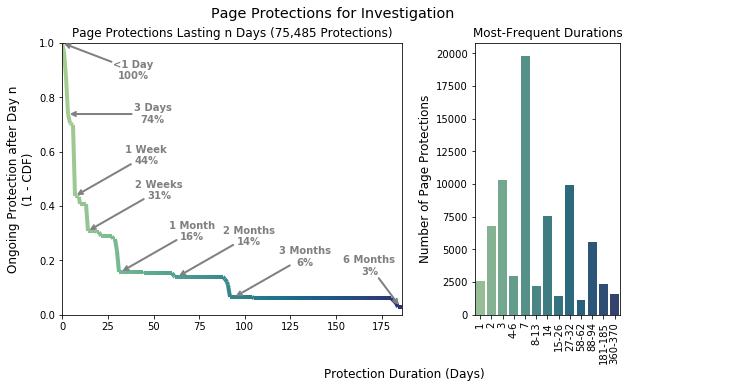

In [14]:
bins_limit = 13
df_spells = df_ns0_exp[df_ns0_exp.type.isin(['spell-not-requested', 'rfpp-protected'])].copy()
df_spells.start, df_spells.end = pd.to_datetime(df_spells.start, utc=True), pd.to_datetime(df_spells.end, utc=True)
df_spells['dummy_type'] = 'edit'
df_edit_spells_all, df_prot_survival_all = compute_duration_dfs(df_spells, type_col='dummy_type')
df_cdf_count, df_hist = compute_cdf_and_plot(df_edit_spells_all, title='Page Protections for Investigation', exclude_infinity=True, bins_limit=bins_limit, filename=None)
most_pp = set(df_hist.sort_values('value', ascending=False)[:bins_limit].duration_days.values)
def sortby(x):
    try:
        return int(x.split('-')[0])
    except ValueError:
        return float('inf')
hue_order = list(sorted(list(most_pp), key=sortby))

In [194]:
df_requests_complete.duration_days = df_requests_complete.duration_days.dt.days

computed was_pp
filtered rows, group now
1807917


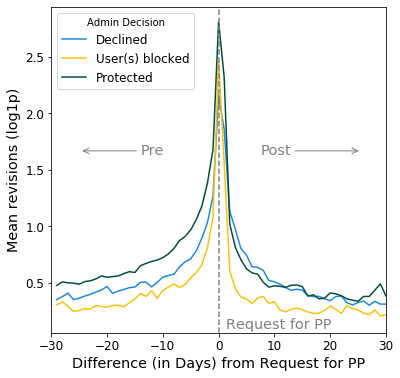

In [1089]:
df_p1 = plot_pre_during_protection_for_requests(df_requests_complete.dropna(subset=['type']), 'revisions', 
                                                limit_days=(-30, 30), page_title_column= 'treated_id', 
                                                filename='requests', save_path='figures/preduring_')

In [1090]:
color_protected = None
handles, labels = df_p1[2].get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label == 'rfpp-protected':
        color_protected = handle.get_color()
print(f'Found color {color_protected}')

Found color #004D40


In [1091]:
df_spell_group_filled_complete.type.value_counts(dropna=False)

spell-not-requested    20808408
rfpp-protected         13051554
Name: type, dtype: int64

filtered rows, group now
3050704


/home/jovyan/work/scripts/descriptive.py:1004: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  palette=None if single_hue else "crest", color=single_hue if single_hue else None)


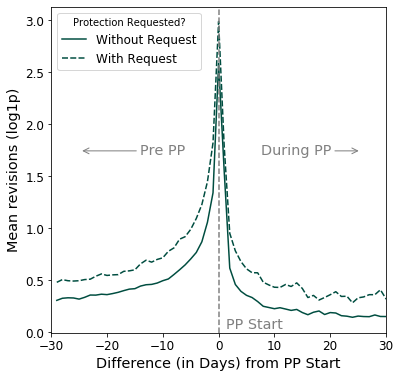

In [1092]:
df_p2 = plot_pre_during_protection_for_spells(df_spell_group_filled_complete, 'revisions', limit_days=(-30, 30), 
                                              page_title_column= 'treated_id', single_hue = color_protected, 
                                              filename='spells', save_path='figures/preduring_')

filtered rows, group now


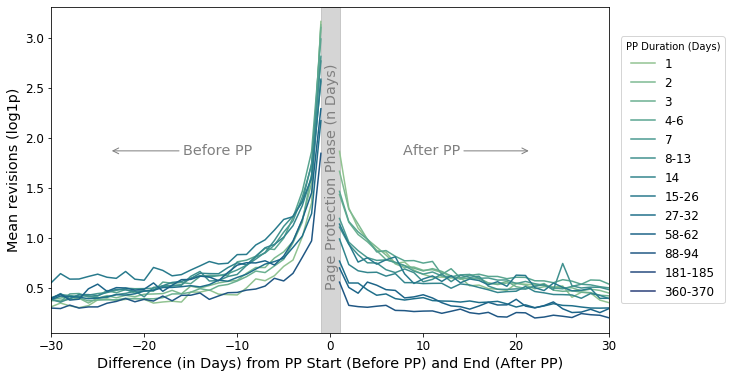

In [140]:
df_p3 = plot_pre_post_prot(df_spell_group_filled_complete, 'revisions', limit_days=(-30, 30), 
                           include_only_hues=most_pp, hue_order=hue_order, page_title_column= 'treated_id', 
                           filename='spells_exp', save_path='figures/prepost_')

# merge with quality metrics

In [37]:
from scripts.retrieve_ores import build_ores_df_from_pickle_files
from scripts.util import chunk_list

In [38]:
df_ores = build_ores_df_from_pickle_files('exp-')

09-24 09:07 : INFO : Created new singleton instance
09-24 09:07 : INFO : Start processing exp-errors_chunk_000_575668228-740294655.pkl


New logging instance for ../logging//ores-compute.log


09-24 09:08 : INFO : Start processing exp-chunk_002_566731215-598684236.pkl
09-24 09:16 : INFO : Start processing exp-new_chunk_001_987935118-754974718.pkl
09-24 09:18 : INFO : Start processing exp-chunk_001_888009956-566731120.pkl
09-24 09:27 : INFO : Start processing exp-missing_parents_chunk_000_0-1010302975.pkl
09-24 09:27 : INFO : Start processing exp-parents2_chunk_000_507986082-506387446.pkl
09-24 09:27 : INFO : Start processing exp-chunk_000_505064337-888009401.pkl
09-24 09:35 : INFO : Start processing exp-new-errors_chunk_000_595629319-919594414.pkl
09-24 09:35 : INFO : Start processing exp-chunk_004_1126115724-1147594805.pkl
09-24 09:36 : INFO : Start processing exp-chunk_003_598684282-1126115617.pkl
09-24 09:44 : INFO : Start processing exp-new_chunk_000_1115684866-786608523.pkl


In [39]:
print(len(df_ores))
df_ores_valid = df_ores[0].query('(Q_pred != "error") & (revision_id != 0)').drop_duplicates(subset=['revision_id'])
print(len(df_ores_valid))

2
12993721


In [40]:
df_content_requests = df_content[(df_content.type != 'spell-not-requested')]
print(len(df_content_requests))
df_content_ores = df_content_requests.merge(df_ores_valid, on='revision_id', how='left')
print(len(df_content_ores.dropna(subset=['Q_score'])))
df_content_ores.head()

5826403
5708475


,event_timestamp,event_user_id,event_user_text_historical,event_user_text,event_user_groups_historical,event_user_is_bot_by_historical,event_user_registration_timestamp,event_user_creation_timestamp,event_user_revision_count,page_id,...,is_HandS,is_Geo,highest_prob_topic,highest_prob_topic_prob,Q_pred,Q_score,prob_gf,is_goodf,prob_dmg,is_dmg
0,2012-01-02 08:45:43+00:00,7328338.0,Yobot,Yobot,bot,"name,group",2008-06-17 22:33:17+00:00,2008-06-17 22:33:18.0,1887339.0,26800279,...,False,True,Culture.Biography.Biography*,0.849581,C,2.52229,0.983301,True,0.017555,False
1,2012-01-12 00:33:51+00:00,NaN,65.8.215.225,65.8.215.225,NaN,NaN,NaT,NaN,NaN,3876181,...,False,True,Culture.Sports,0.996134,Start,1.380405,0.742269,True,0.345934,False
2,2012-01-13 18:41:42+00:00,14770536.0,89spaceman,89spaceman,NaN,NaN,2011-06-15 00:54:29+00:00,2011-06-15 00:54:30.0,127.0,11515474,...,True,True,History and Society.Business and economics,0.915118,Stub,0.491167,0.953157,True,0.118662,False
3,2012-01-15 04:04:53+00:00,2359527.0,Tgeairn,Thirdright,rollbacker,NaN,2006-09-29 17:58:56+00:00,2006-09-29 17:58:57.0,13013.0,24326691,...,True,True,History and Society.Education,0.996536,Stub,0.339535,0.989260,True,0.009442,False
4,2012-01-20 02:50:26+00:00,1215485.0,Cydebot,Cydebot,"bot,sysop","name,group",2006-04-07 01:24:50+00:00,2006-04-07 01:24:50.0,3440884.0,32539308,...,False,True,Geography.Regions.Asia.Asia*,0.948244,Stub,0.045898,0.991751,True,0.008742,False


# metrics before/after

In [41]:
from scripts.matching import compute_n_qualities_before_ts, compute_n_qualities_after_ts, compute_n_pagesize_before_ts, compute_n_page_age_before_ts, compute_n_topics_before_ts

In [42]:
# 1 minute before
df_all_minute_q, df_stats_minute_q = compute_n_qualities_before_ts(df_content_ores, 'treated_id', 'request_timestamp', q_sum_col='Q_score', n=10,
                                                            delta_ts=pd.to_timedelta('1 Minute'))
df_q_minute_merge = df_stats_minute_q[['treated_id', 'Max_Q_score']].rename({'Max_Q_score': 'Q_score'}, axis=1)

df_minute_pagesize, df_stats_minute_ps = compute_n_pagesize_before_ts(df_content_ores, 'treated_id', 'request_timestamp', n=10,
                                                            delta_ts=pd.to_timedelta('1 Minute'))
df_ps_minute_merge = df_stats_minute_ps[['treated_id', 'Max_revision_text_bytes']].rename({'Max_revision_text_size': 'pagesize'}, axis=1)

df_page_minute_age, df_stats_minute_age = compute_n_page_age_before_ts(df_content_ores, 'treated_id', 'request_timestamp', n=10,
                                                            delta_ts=pd.to_timedelta('1 Minute'))
df_age_minute_merge = df_stats_minute_age[['treated_id', 'Latest_page_revision_count']].rename({'Latest_page_revision_count': 'page_age'}, axis=1)


In [310]:
df_topics_m, df_sel_topic_m = compute_n_topics_before_ts(df_content_ores, 'treated_id', 'request_timestamp', n=20, delta_ts=pd.to_timedelta('1 minute'))


Dropped 101346 of 2693203 rows due to invalid topics


In [311]:
df_articlemetrics_minute = df_sel_topic_m.reset_index().merge(df_q_minute_merge, on='treated_id', how='outer').merge(
    df_ps_minute_merge, on='treated_id', how='outer').merge(df_age_minute_merge, on='treated_id', how='outer')
print(len(df_articlemetrics_minute[pd.isna(df_articlemetrics_minute.is_STEM)]), 'articles with no definite topic')
print(len(df_articlemetrics_minute[pd.isna(df_articlemetrics_minute.Q_score)]), 'articles with no definite quality')

1303 articles with no definite topic
956 articles with no definite quality


In [312]:
df_articlemetrics_minute[pd.isna(df_articlemetrics_minute.Max_revision_text_bytes)]

,treated_id,is_STEM,is_Culture,is_HandS,is_Geo,Q_score,Max_revision_text_bytes,page_age
40045,70282,NaN,NaN,NaN,NaN,NaN,NaN,48
40046,91830,NaN,NaN,NaN,NaN,NaN,NaN,4
40047,92254,NaN,NaN,NaN,NaN,NaN,NaN,80
40048,97179,NaN,NaN,NaN,NaN,NaN,NaN,15


In [24]:
df_control_metrics_minute = df_pretreat_metrics.merge(
    df_articlemetrics_minute, on='treated_id', how='outer')

## Collect Weekly/Daily metrics

In [567]:
from scripts.matching import create_staggered_did

In [ ]:
df_content_ores.page_is_redirect

In [613]:
np.sum(df_content_ores.page_is_redirect == False)

5604020

In [55]:
df_content_ores['is_dmg'] = df_content_ores['is_dmg'].fillna(False).astype(bool)
df_content_ores['is_goodf'] = df_content_ores['is_goodf'].fillna(False).astype(bool)
df_content_ores['revision_is_identity_reverted'] = df_content_ores['revision_is_identity_reverted'].fillna(False).astype(bool)
df_content_ores['revision_is_identity_revert'] = df_content_ores['revision_is_identity_revert'].fillna(False).astype(bool)

df_content_ores['revision_text_bytes'] = pd.to_numeric(df_content_ores.revision_text_bytes, errors='coerce')
df_content_ores['page_revision_count'] = pd.to_numeric(df_content_ores.page_revision_count, errors='coerce')

In [56]:
df_ns0_exp.request_timestamp = pd.to_datetime(df_ns0_exp.request_timestamp, errors='coerce', utc=True)

In [153]:
df_ns0_exp.duration_days = pd.to_timedelta(df_ns0_exp.duration_days, unit='days', errors='coerce')

In [ ]:
df_did_complete_sample = create_staggered_did(df_content_ores.copy(), df_ns0_exp, period='week')


In [ ]:
df_did_complete = create_staggered_did(df_content_ores.copy(), df_ns0_exp, period='week')

In [594]:
df_did_complete_day = create_staggered_did(df_content_ores.copy(), df_ns0_exp, period='day')

This should be 0 0
Overall: 599387
This should be 0 0
Overall: 1312739


In [ ]:
min_week_data = 4
df_minweeks = df_did_complete.groupby('treated_id').request_diff_week.min().reset_index()
df_minweeks = df_minweeks[df_minweeks.request_diff_week > -min_week_data]
df_minweeks

In [602]:
min_day_data = min_week_data * 7
df_min_days = df_did_complete_day.groupby('treated_id').request_diff_day.min().reset_index()
df_min_days = df_min_days[df_min_days.request_diff_day > -min_day_data]
df_min_days.request_diff_day

2       -12
4       -16
23       -3
40        7
49      -11
         ..
39231   -25
39239    -4
39249    -1
39254    -4
39261    -1
Name: request_diff_day, Length: 2807, dtype: int64

In [969]:
df_did_q_matching = df_did_complete_day[~df_did_complete_day.treated_id.isin(
    df_min_days.treated_id.values) & df_did_complete_day.request_diff_day.isin([
    -28, -22, -21, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1])]
df_prequality_max = df_did_q_matching.pivot(
    index='treated_id', columns='request_diff_day', values='articlequality_max')
df_prequality_last = df_did_q_matching.pivot(
    index='treated_id', columns='request_diff_day', values='articlequality_last')
df_prequality_max.columns = [f'Q_score_max_{str(c).replace("-", "m")}' for c in df_prequality_max.columns]
df_prequality_last.columns = [f'Q_score_last_{str(c).replace("-", "m")}' for c in df_prequality_last.columns]

In [970]:
df_did_complete_withcont = df_did_complete[~df_did_complete.treated_id.isin(
    df_minweeks.treated_id.values)].merge(df_control_metrics_minute, on='treated_id', how='left').merge(
    df_prequality_max, on='treated_id', how='left').merge(
    df_prequality_last, on='treated_id', how='left')
df_did_complete_withcont.to_csv('data/experiment/did-weeks-bugfix.csv', index=False)

In [964]:
df_did_complete_day_withcont = df_did_complete_day[~df_did_complete_day.treated_id.isin(
    df_min_days.treated_id.values)].merge(df_control_metrics_minute, on='treated_id', how='left').merge(
    df_prequality, on='treated_id', how='left')

In [599]:
df_did_complete_day_withcont = df_did_complete_day[~df_did_complete_day.treated_id.isin(
    df_min_days.treated_id.values)].merge(df_control_metrics_minute, on='treated_id', how='left').merge(
    df_prequality, on='treated_id', how='left')
df_did_complete_day_withcont.to_csv('data/experiment/did-days-bugfix.csv', index=False)

In [ ]:
df_regression_minute['Q_score_quantile'] = pd.qcut(df_regression_minute['Q_score'], q=4, labels=['low', 'medium-low', 'medium-high', 'high'])


In [1133]:
# df that can be used for matching
max_protection_length = 93
df_regression_minute = df_prequality_max.merge(df_prequality_last, on='treated_id', how='left').merge(
    df_treated[pd.isna(df_treated.level) | (df_treated.level == 'autoconfirmed')][['treated_id', 'type', 'request_timestamp', 'duration_days']],
    on='treated_id', how='left').merge(
    df_control_metrics_minute, on='treated_id', how='left').dropna(subset=['type'])
df_regression_minute.request_timestamp = pd.to_datetime(df_regression_minute.request_timestamp, utc=True)

df_regression_minute['day_of_request'] = (df_regression_minute.request_timestamp - pd.to_datetime('2000-01-01', utc=True)).dt.days
df_regression_minute['week_of_request'] = (df_regression_minute.request_timestamp - pd.to_datetime('2000-01-01', utc=True)) // pd.to_timedelta('7 days')
df_regression_minute['year_of_request'] = df_regression_minute.request_timestamp.dt.year
df_regression_minute.duration_days = df_regression_minute.duration_days.dt.days

topic_cols = np.array(['is_Geo', 'is_HandS', 'is_STEM', 'is_Culture'])
df_regression_minute['Topics'] = df_regression_minute[topic_cols].apply(lambda row: ', '.join(topic_cols[row.fillna(False)]).replace('is_', ''), axis=1).replace({'': 'Undefined'})
df_regression_minute['Q_score_quantile'] = pd.qcut(df_regression_minute['Q_score_max_m1'], q=4, labels=['low', 'medium-low', 'medium-high', 'high'])
df_regression_minute['Max_revision_text_bytes_log'] = np.log(df_regression_minute.Max_revision_text_bytes)
df_regression_minute['page_size_quantile'] = pd.qcut(df_regression_minute['Max_revision_text_bytes_log'], q=4, labels=['small', 'medium-small', 'medium-large', 'large'])

df_regression_minute[~df_regression_minute.treated_id.isin(df_min_days.treated_id.values) &
                    (pd.isna(df_regression_minute.duration_days) |
                     (df_regression_minute.duration_days < max_protection_length))].to_csv(
    'data/experiment/complete-regression-df-mindays-minute.csv', index=False)

In [1151]:
len(set(df_long) - set(df_high)) / len(df_long)

0.388568194680249

In [1152]:
len(set(df_high) - set(df_long)) / len(df_high)

0.388568194680249

In [1184]:
df_regression_minute.Q_score_max_m1.corr(df_regression_minute.Max_revision_text_bytes_log, method='spearman')

0.8271227769552224

In [ ]:
ddf_pairs.merge(how='left')

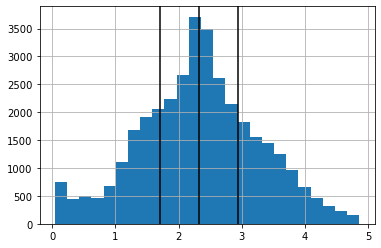

In [1101]:
q_scores = df_regression_minute['Q_score_max_m1']
ax = q_scores.hist(bins=25)
ax.axvline(q_scores.quantile(0.25), color='black')
ax.axvline(q_scores.quantile(0.5), color='black')
ax.axvline(q_scores.quantile(0.75), color='black')

In [1134]:
page_size.quantile(0.25)

8.955964118230876

In [1135]:
page_size.quantile(0.75)

10.34600756820839

In [1128]:
np.exp(0.8486971822023752)

2.336600703086467

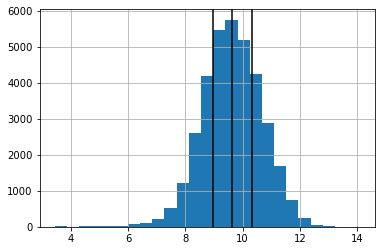

In [1132]:
page_size = df_regression_minute['Max_revision_text_bytes_log'] = np.log(df_regression_minute.Max_revision_text_bytes)
ax = page_size.hist(bins=25)
ax.axvline(page_size.quantile(0.25), color='black')
ax.axvline(page_size.quantile(0.5), color='black')
ax.axvline(page_size.quantile(0.75), color='black')

In [ ]:
df_regression_minute['Topics'] = df_regression_minute[topic_cols].apply(lambda row: ', '.join(topic_cols[row.fillna(False)]).replace('is_', ''), axis=1).replace({'': 'Undefined'})

In [243]:
df_did_complete_withcont.duration_days = df_did_complete_withcont.duration_days.dt.days

In [244]:
df_did_complete_filtered = df_did_complete_withcont[~df_did_complete_withcont.treated_id.isin(df_min_days.treated_id.values) & (pd.isna(df_did_complete_withcont.duration_days) |
    (df_did_complete_withcont.duration_days < max_protection_length))]

In [ ]:
weekly_revs_after_protection = df_did_complete_filtered.query('(request_diff_week >= 0) & (request_diff_week <= 4)').groupby(['treated_id']).revisions.sum().reset_index().query('revisions == 0')
no_activity_within_month = weekly_revs_after_protection.merge(df_ns0_exp, how='left', on='treated_id')
no_activity_within_month

### Articlequality

In [569]:
from scripts.preprocessing import combine_ranges
COL_BLIND_PALETTE_3

In [1171]:
df_aq_vis = df_did_complete_day_withcont.copy() #[~df_did_complete_day.treated_id.isin(
    #df_min_days.treated_id.values)].copy()
    
df_aq_vis['grouped_days'] = df_aq_vis.duration_days.dt.days.apply(combine_ranges)
df_aq_vis['user_type'] = 'custom-comp'
df_aq_vis['start'] = None
df_aq_vis['level'] = None
df_aq_vis.duration_days = df_aq_vis.duration_days.dt.days

computed was_pp
filtered rows, group now
4208187


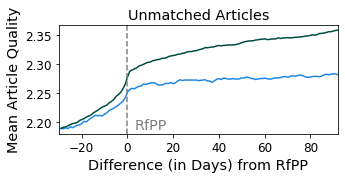

In [1252]:
df_p1 = plot_pre_during_protection_for_requests(
    df_aq_vis[(df_aq_vis.type != 'rfpp-userint')].rename(
        {'articlequality_last': 'Article Quality'}, axis=1).copy(), 'Article Quality', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'treated_id', filename='unmatched', title='Unmatched Articles',
    log=False, ignore_ended_protections=False, metric='mean', figsize=(5,2))

# load matched dataframe


In [1212]:
df_pairs = pd.read_csv('data/experiment/pairs-final.csv')
df_pairs.rename({'Unnamed: 0': 'R_index'}, axis=1, inplace=True)

df_pairs['duration_days'] = df_pairs.groupby('subclass')['duration_days'].transform(
    'first')
df_pairs['Q_score_quantile'] = df_pairs.groupby('subclass')['Q_score_quantile'].transform(
    'first')
df_pairs['page_size_quantile'] = df_pairs.groupby('subclass')['page_size_quantile'].transform(
    'first')

In [1214]:
df_pairs_ext = df_pairs.merge(
    df_aq_vis[['treated_id', 'request_diff_day', 'articlequality_max',  'articlequality_last', 'revisions', 'page_size_max', 
               'revision_diff_bytes_sum', 'revision_diff_bytes_abs_sum', 'identity_reverts', 'identity_reverted',
               'damaging_count', 'goodfaith_count','goodfaith', 'damaging',
               'grouped_days', 'user_type', 'start', 'level', 'is_pp_req']],
    on='treated_id', how='left')

computed was_pp
filtered rows, group now
5941664


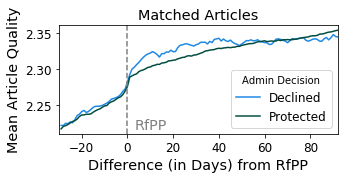

In [1254]:
df_p1 = plot_pre_during_protection_for_requests(
    df_pairs_ext.rename(
        {'articlequality_last': 'Article Quality'}, axis=1).copy(), 'Article Quality', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'R_index', filename='matched', title='Matched Articles',
    log=False, ignore_ended_protections=False, metric='mean', figsize=(5,2))

computed was_pp
filtered rows, group now
1468303


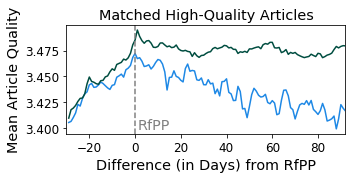

In [1253]:
df_p1 = plot_pre_during_protection_for_requests(
    df_pairs_ext.query('Q_score_quantile == "high"').rename(
        {'articlequality_last': 'Article Quality'}, axis=1).copy(), 'Article Quality', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'R_index', filename='matched_high',
    log=False, ignore_ended_protections=False, metric='mean', figsize=(5,2),
title='Matched High-Quality Articles')



computed was_pp
filtered rows, group now
1462139


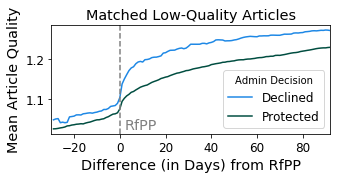

In [1249]:
df_p1 = plot_pre_during_protection_for_requests(
    df_pairs_ext.query('Q_score_quantile == "low"').rename(
        {'articlequality_last': 'Article Quality'}, axis=1).copy(), 'Article Quality', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'R_index', filename='matched_low',
    log=False, ignore_ended_protections=False, metric='mean', figsize=(5,2),
title='Matched Low-Quality Articles')


computed was_pp
filtered rows, group now
1092554


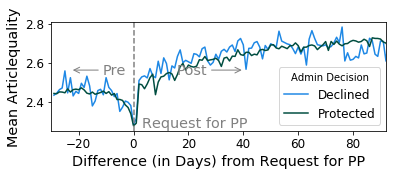

In [1168]:
df_p1 = plot_pre_during_protection_for_requests(
    df_pairs_ext.query('revisions > 0').rename(
        {'articlequality_last': 'Articlequality'}, axis=1).copy(), 'Articlequality', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'R_index', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

### Revision text bytes

computed was_pp
filtered rows, group now
413130


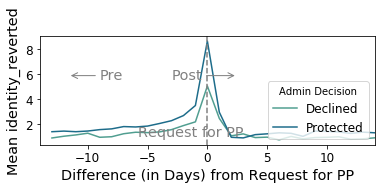

In [1036]:
df_p1 = plot_pre_during_protection_for_requests(
    df_pairs_ext.query('revisions > 0').copy(), 'identity_reverted', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-14, 14), page_title_column= 'R_index', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

computed was_pp
filtered rows, group now
1086048


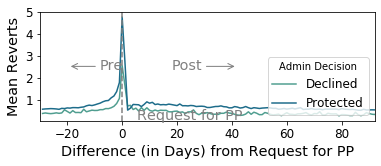

In [1038]:
df_p1 = plot_pre_during_protection_for_requests(
    df_pairs_ext.query('revisions > 0').rename(
        {'identity_reverts': 'Reverts'}, axis=1).copy(), 'Reverts', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'R_index', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

computed was_pp
filtered rows, group now
4469320


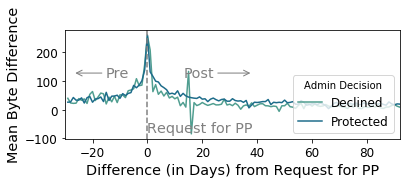

In [1039]:
df_p2 = plot_pre_during_protection_for_requests(
    df_aq_vis[(df_aq_vis.type != 'rfpp-userint')].rename(
        {'revision_diff_bytes_sum': 'Byte Difference'}, axis=1).copy(), 'Byte Difference', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'treated_id', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

In [1040]:
df_pair_content = df_content_ores[df_content_ores['treated_id'].isin(set(df_pairs.treated_id))]

In [442]:
print(len(df_pair_content))
df_pair_content = df_pair_content[(df_pair_content.request_diff >= -pd.Timedelta(days=7)) & 
                                  (df_pair_content.request_diff <= pd.Timedelta(days=7))]
print(len(df_pair_content))

4045359
1143776


In [447]:
df_pair_content.to_csv(
    'data/experiment/df_content_7days.csv', index=False)

# Editquality??

In [1041]:
df_edits = df_aq_vis.query('revisions > 0').copy()
df_edits['damaging_perc'] = df_edits.damaging_count / df_edits.revisions
df_edits['goodfaith_perc'] = df_edits.goodfaith_count / df_edits.revisions

In [1042]:
df_pairs_edits = df_pairs_ext.query('revisions > 0').copy()
df_pairs_edits['damaging_perc'] = df_pairs_edits.damaging_count / df_pairs_edits.revisions
df_pairs_edits['goodfaith_perc'] = df_pairs_edits.goodfaith_count / df_pairs_edits.revisions

computed was_pp
filtered rows, group now
871505


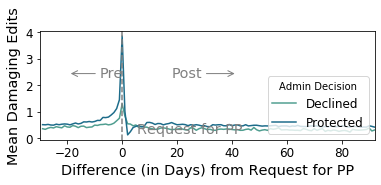

In [1043]:
df_p1 = plot_pre_during_protection_for_requests(
    df_edits.rename(
        {'damaging_count': 'Damaging Edits'}, axis=1), 'Damaging Edits', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'treated_id', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

computed was_pp
filtered rows, group now
871505


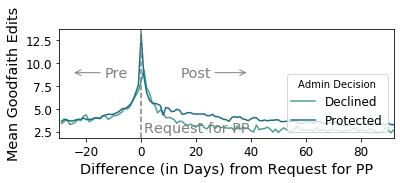

In [1044]:
df_p1 = plot_pre_during_protection_for_requests(
    df_edits.rename(
        {'goodfaith_count': 'Goodfaith Edits'}, axis=1), 'Goodfaith Edits', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'treated_id', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

computed was_pp
filtered rows, group now
871505


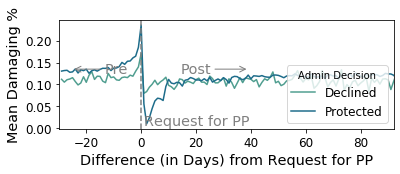

In [1045]:
df_p1 = plot_pre_during_protection_for_requests(
    df_edits.rename(
        {'damaging_perc': 'Damaging %'}, axis=1), 'Damaging %', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'treated_id', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

computed was_pp
filtered rows, group now
871505


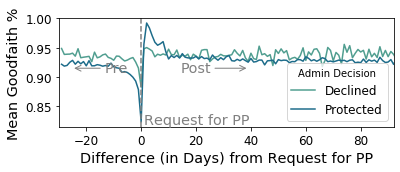

In [1046]:
df_p1 = plot_pre_during_protection_for_requests(
    df_edits.rename(
        {'goodfaith_perc': 'Goodfaith %'}, axis=1), 'Goodfaith %', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'treated_id', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

computed was_pp
filtered rows, group now
1086048


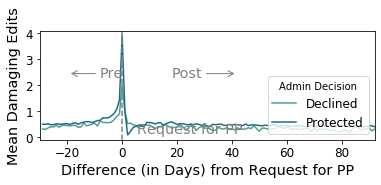

In [1047]:
df_p1 = plot_pre_during_protection_for_requests(
    df_pairs_ext.query('revisions > 0').rename(
        {'damaging_count': 'Damaging Edits'}, axis=1), 'Damaging Edits', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'R_index', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

computed was_pp
filtered rows, group now
1086048


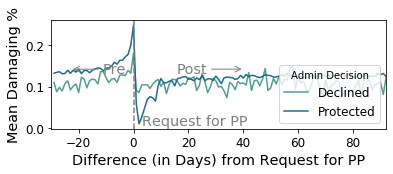

In [1048]:
df_p1 = plot_pre_during_protection_for_requests(
    df_pairs_edits.query('revisions > 0').rename(
        {'damaging_perc': 'Damaging %'}, axis=1), 'Damaging %', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'R_index', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

computed was_pp
filtered rows, group now
1086048


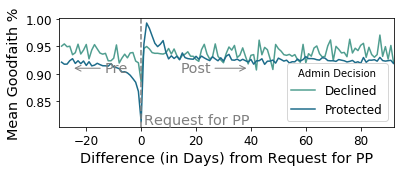

In [1049]:
df_p1 = plot_pre_during_protection_for_requests(
    df_pairs_edits.query('revisions > 0').rename(
        {'goodfaith_perc': 'Goodfaith %'}, axis=1).copy(), 'Goodfaith %', 
    hue_order={'rfpp-declined': 'Declined', 'rfpp-protected': 'Protected'},
    limit_days=(-30, 92), page_title_column= 'R_index', filename=None,
    log=False, ignore_ended_protections=False, metric='mean', figsize=(6,2))

# Manual investigation

In [1119]:
df_pairs_new = pd.read_csv('data/experiment/pairs-final.csv')
df_pairs_new.rename({'Unnamed: 0': 'R_index'}, axis=1, inplace=True)

In [1122]:
df_pairs_new[~df_pairs_new.treated_id.isin(df_pairs.treated_id)]

,R_index,id,subclass,weights,treated_id,Q_score_max_m28,Q_score_max_m22,Q_score_max_m21,Q_score_max_m15,Q_score_max_m14,...,revisions_productive_1H_log,revisions_productive_24H_log,revisions_productive_168H_log,identity_reverts_1H_log,identity_reverts_24H_log,identity_reverts_168H_log,Max_revision_text_bytes_log,page_age_log,page_size_log,distance
12,13,7,7,1,53852,1.888139,1.888139,1.888139,1.888139,1.888139,...,0.000000,0.000000,1.609438,0.000000,0.000000,1.609438,8.866017,5.726848,8.866017,0.704223
54,55,29,28,1,53884,1.605705,1.863726,1.863726,1.976741,2.021119,...,1.609438,2.079442,3.367296,1.609438,2.079442,3.367296,9.430439,5.068904,9.430439,0.945199
83,84,26741,42,1,90565,0.097032,0.097717,0.097717,0.097717,0.097717,...,0.693147,1.098612,0.000000,0.693147,1.098612,0.000000,7.514255,4.465908,7.514255,0.777253
100,101,56,51,1,53928,0.082698,0.082698,0.082698,0.083244,0.466392,...,1.945910,4.204693,1.945910,1.945910,4.204693,1.945910,7.878155,5.023881,7.878155,0.979095
140,141,79,71,1,53961,3.209595,3.222632,3.222632,3.191745,3.185312,...,0.000000,2.995732,2.302585,0.000000,2.995732,2.302585,10.486513,5.840642,10.486513,0.880870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48149,48150,30927,24075,1,99050,2.384533,2.384533,2.384533,2.384533,2.384533,...,0.000000,0.693147,0.693147,0.000000,0.693147,0.693147,10.498360,7.307873,10.498360,0.696254
48179,48180,28530,24090,1,93962,3.173903,3.173903,3.173903,3.173903,3.173903,...,1.098612,0.000000,0.000000,1.098612,0.000000,0.000000,10.181990,3.401197,10.181990,0.533682
48208,48209,25566,24105,1,87891,1.983583,2.008114,2.035108,2.002139,2.002139,...,2.197225,3.044522,1.098612,2.197225,3.044522,1.098612,9.336180,4.488636,9.336180,0.940645
48252,48253,25588,24127,1,87916,3.060417,3.076600,2.659389,3.237339,3.167688,...,0.000000,2.197225,2.484907,0.000000,2.197225,2.484907,9.685642,4.934474,9.685642,0.847361


In [1050]:
df_for_inv = df_pairs[['treated_id', 'subclass', 'treated']].merge(
    df_did_complete.query('(request_diff_week == -1) | (request_diff_week == 0) | (request_diff_week == 12)')[['treated_id', 'request_diff_week', 'revision_id_last', 'articlequality_last']],
    on='treated_id', how='left').merge(df_ns0_exp[['treated_id', 'norm_title']], on='treated_id', how='left')
df_for_inv.revision_id_last = df_for_inv.revision_id_last.astype(int)

In [ ]:
df_for_inv2 = df_pairs_new[['treated_id', 'subclass', 'treated']].merge(
    df_did_complete.query('(request_diff_week == -1) | (request_diff_week == 0) | (request_diff_week == 12)')[['treated_id', 'request_diff_week', 'revision_id_last', 'articlequality_last']],
    on='treated_id', how='left').merge(df_ns0_exp[['treated_id', 'norm_title']], on='treated_id', how='left')
df_for_inv2.revision_id_last = df_for_inv.revision_id_last.astype(int)

In [1051]:
import pandas as pd

# Your original DataFrame
# Assuming it's named df
df = df_for_inv

def pivot_dataframe(dataframe):
    pivot = dataframe.pivot(index='subclass', columns='request_diff_week',
                            values=['norm_title', 'revision_id_last', 
                                    'articlequality_last', 'treated_id'])
    pivot.columns = [f'{col[0]}_{col[1]}' for col in pivot.columns]
    return pivot

# Merge the two pivoted DataFrames on 'subclass'
result = pd.merge(pivot_dataframe(df[df['treated'] == False]), 
                  pivot_dataframe(df[df['treated'] == True]),
                  on='subclass', suffixes=('_c', '_t'))

# Rename columns as per your specified format
result = result.rename(columns={
    'norm_title_-1_c': 'c_title',
    'treated_id_-1_c': 'c_treated_id',
    'revision_id_last_-1_c': 'c_revid_m1',
    'revision_id_last_0_c': 'c_revid_0',
    'revision_id_last_12_c': 'c_revid_12',
    'articlequality_last_-1_c': 'c_quality_m1',
    'articlequality_last_0_c': 'c_quality_0',
    'articlequality_last_12_c': 'c_quality_12',
    'norm_title_-1_t': 't_title',
    'treated_id_-1_t': 't_treated_id',
    'revision_id_last_-1_t': 't_revid_m1',
    'revision_id_last_0_t': 't_revid_0',
    'revision_id_last_12_t': 't_revid_12',
    'articlequality_last_-1_t': 't_quality_m1',
    'articlequality_last_0_t': 't_quality_0',
    'articlequality_last_12_t': 't_quality_12'
})

# Reset the index
result.reset_index(inplace=True)

# If you want to fill any NaN values, you can use result.fillna(...) as needed.

# Print the resulting DataFrame
result = result.reset_index(drop=True).drop(
    labels=['norm_title_0_t', 'norm_title_12_t', 'norm_title_0_c', 'norm_title_12_c',
           'treated_id_0_t', 'treated_id_12_t', 'treated_id_0_c', 'treated_id_12_c'], axis=1)
result.head()

,subclass,c_title,c_revid_m1,c_revid_0,c_revid_12,c_quality_m1,c_quality_0,c_quality_12,c_treated_id,t_title,t_revid_m1,t_revid_0,t_revid_12,t_quality_m1,t_quality_0,t_quality_12,t_treated_id
0,1,Artsrun_Hovhannisyan,1043344537,1043344537,1054288869,2.615207,2.615207,2.626772,90723,Tariq_ibn_Ziyad,520394511,520402410,532836872,2.474378,2.475636,2.515186,53838
1,2,Vinny_Guadagnino,1121182320,1121334960,1138010334,2.322461,2.322461,2.335515,88785,Shatrughan_Sinha,520393609,520705061,534434208,2.330101,2.313275,2.320016,53839
2,3,Deacon_Jones,558272922,559306718,567064409,2.505919,3.16125,3.246531,101558,Bulgaria_national_football_team,520469165,521145577,534470072,2.740033,2.5418,0.083113,53841
3,4,Pot_pie,930919481,930919481,945289850,1.736136,1.736136,1.736136,93324,Vortexx,520525971,521415590,534981701,1.903621,1.868522,1.938801,53843
4,5,American_mutilation_of_Japanese_war_dead,924948869,925818863,937350123,3.680867,3.680867,3.689631,93479,Winter_War,520564761,520584864,534836302,3.499284,3.49099,3.494848,53847


In [1052]:
clickable=True
def make_clickable(url, name):
    return '<a href="{}" rel="noopener noreferrer" target="_blank">{}</a>'.format(url,name)

def build_wiki_diff_link(t):
    new_cols = []
    for g in ['c', 't']:
        for n in ['0', '12']:
            revid_old = t[f'{g}_revid_m1']
            revid_new = t[f'{g}_revid_{n}']
            link = f"https://en.wikipedia.org/w/index.php?diff={revid_new}&oldid={revid_old}"
            if clickable:
                link = make_clickable(link, f'{revid_old}->{revid_new}')
            new_cols.append(link)
    return new_cols

In [1053]:
new_cols = result.apply(build_wiki_diff_link, axis=1)

In [1054]:
result['t_change_0'] = result['t_quality_0'] - result['t_quality_m1'] 
result['t_change_12'] = result['t_quality_12'] - result['t_quality_m1'] 

result['c_change_0'] = result['c_quality_0'] - result['c_quality_m1'] 
result['c_change_12'] = result['c_quality_12'] - result['c_quality_m1'] 

In [1055]:
result[['c_diff_0', 'c_diff_12', 't_diff_0', 't_diff_12']] = pd.DataFrame(zip(*new_cols)).T

In [1056]:
eval_sample = result[['subclass', 'c_title', 'c_quality_m1', 'c_diff_0', 'c_change_0', 'c_diff_12',  'c_change_12', 't_title', 't_quality_m1', 't_diff_0', 't_change_0', 't_diff_12', 't_change_12']].sample(100)

In [ ]:
eval_sample[['c_title', 'c_quality_m1', 'c_diff_0', 'c_change_0', 'c_diff_12',  'c_change_12', 't_title', 't_quality_m1', 't_diff_0', 't_change_0', 't_diff_12', 't_change_12']].style

In [996]:
eval_sample.to_csv('data/experiment/quality_eval.csv')

In [1086]:
df_did_complete_paired = df_did_complete_withcont[(df_did_complete_withcont.request_diff_week >= -4)& (df_did_complete_withcont.request_diff_week <= 12)]

In [1087]:
df_did_complete_paired.revision_id_last.astype(int).unique().size

349444

In [1088]:
df_did_complete_withcont[(df_did_complete_withcont.request_diff_week >= -4)& (df_did_complete_withcont.request_diff_week <= 12)].revision_id_last.astype(int).to_csv('data/experiment/experiment_eow_ids.csv')


In [1027]:
df_did_complete_withcont.query('(request_diff_week == -1 and treated_id == 102264) |'
                                '(request_diff_week == -1 and treated_id == 75819)')[['Q_score_last_m1', 'articlequality_last']]

,Q_score_last_m1,articlequality_last
510731,4.383389,4.383389
1062411,0.146095,0.146095


In [1008]:
df_did_complete_withcont.query('(request_diff_week == -1 and treated_id == 61000) |'
                                '(request_diff_week == -1 and treated_id == 95511)')[['Q_score_last_m1', 'articlequality_last']]

,Q_score_last_m1,articlequality_last
165213,0.052413,0.052413
953537,0.465628,0.465628


In [1010]:
df_did_complete_day.query('(request_diff_day == -1 and treated_id == 61000) |'
                                '(request_diff_day == -1 and treated_id == 95511)')[['articlequality_last']]

,articlequality_last
1166218,0.052413
6799614,0.465628


In [854]:
result.to_csv('data/match_investigations.csv')